In [ ]:
import gc
import pandas as pd
import numpy as np

In [ ]:
%%capture
%pip install dask[dataframe]
%pip install "dask[distributed]"
%pip install memory_profiler

In [ ]:
#@title Mounting Collab

from google.colab import drive
import pandas as pd

# Step 1: Mount Google Drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Reading files both train and test

import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data with the first 1000 rows
train_df = pd.read_csv("/content/drive/MyDrive/train_1.csv")
train2_1_df = pd.read_csv("/content/drive/MyDrive/train_2_1.csv")
train2_2_df = pd.read_csv("/content/drive/MyDrive/train_2_2.csv")

test_df = pd.read_csv("/content/drive/MyDrive/test_1.csv")
test2_1_df = pd.read_csv("/content/drive/MyDrive/test_2_1.csv")
test2_2_df = pd.read_csv("/content/drive/MyDrive/test_2_2.csv")


# Display the shapes of each component to verify
print("train_df:", train_df.shape)
print("train2_1_df:", train2_1_df.shape)
print("train2_2_df:", train2_2_df.shape)


<ipython-input-6-a01db46bb7f4>:7: DtypeWarning: Columns (126,128,143) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("/content/drive/MyDrive/train_1.csv")
<ipython-input-6-a01db46bb7f4>:8: DtypeWarning: Columns (675,676,677) have mixed types. Specify dtype option on import or set low_memory=False.
  train2_1_df = pd.read_csv("/content/drive/MyDrive/train_2_1.csv")
<ipython-input-6-a01db46bb7f4>:9: DtypeWarning: Columns (675,676,677) have mixed types. Specify dtype option on import or set low_memory=False.
  train2_2_df = pd.read_csv("/content/drive/MyDrive/train_2_2.csv")


train_df: (100000, 168)
train2_1_df: (90300, 678)
train2_2_df: (47976, 678)


In [ ]:
#@title Proess Train and test data

import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import gc

class DataProcessor:
    def __init__(self):
        self.encoders: Dict = {}
        self.categorical_columns = [
            'prod', 'col_114', 'col_117', 'col_118', 'col_123',
            'col_140', 'col_150', 'col_156', 'col_157', 'col_158', 'col_161', 'col_148'
        ]
        self.cols_to_drop = [f'add_{i}' for i in [431, 671, 672, 673, 675, 676, 677]]

    def calculate_means_for_duplicates(self, df: pd.DataFrame, suffix: str) -> pd.DataFrame:
        """Calculate means for each unique ID in the additional data"""
        # Drop unnecessary columns
        df = df.drop(columns=[col for col in self.cols_to_drop if col in df.columns])

        # Get numeric columns
        numeric_cols = df.select_dtypes(exclude=['object']).columns

        # Group by ID and calculate means
        means_df = df.groupby('id')[numeric_cols].mean().reset_index()

        # Add suffix to column names except 'id'
        rename_dict = {col: f"{col}{suffix}" for col in means_df.columns if col != 'id'}
        means_df = means_df.rename(columns=rename_dict)

        del df
        gc.collect()

        return means_df

    def encode_categorical(self, df: pd.DataFrame, is_training: bool = True) -> pd.DataFrame:
        """
        Encode categorical columns.
        During training, create encodings; during testing, use existing encodings.
        """
        for col in self.categorical_columns:
            if col in df.columns:
                if is_training:
                    # During training, create new encodings
                    unique_values = df[col].unique()
                    self.encoders[col] = {val: idx + 1 for idx, val in enumerate(unique_values)}

                # Transform values using encodings (same for both train and test)
                df[col] = (
                    df[col]
                    .map(self.encoders.get(col, {}))
                    .fillna(0)
                    .astype('int32')
                )
        return df

    def process_special_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process special columns that need specific handling"""
        if 'col_116' in df.columns:
            df['col_116'] = pd.to_numeric(df['col_116'], errors='coerce').fillna(0).astype('float32')

        if 'col_125' in df.columns:
            df['col_125_NR'] = (df['col_125'] == 'NR').astype('int8')
            df['col_125_numeric'] = (
                pd.to_numeric(df['col_125'].replace('NR', np.nan), errors='coerce')
                .fillna(0)
                .astype('float32')
            )
            df = df.drop('col_125', axis=1)

        return df

    def fit_transform(self, train_df: pd.DataFrame, train2_1: pd.DataFrame, train2_2: pd.DataFrame) -> pd.DataFrame:
        """
        Process training data:
        1. Calculate means for additional training data independently
        2. Create categorical encodings
        3. Process special columns
        """
        # Calculate means for additional training data
        print("Processing train2_1...")
        train2_1_means = self.calculate_means_for_duplicates(train2_1.copy(), '_21')
        print("Processing train2_2...")
        train2_2_means = self.calculate_means_for_duplicates(train2_2.copy(), '_22')

        # Merge all training dataframes
        print("Merging training dataframes...")
        merged_df = (train_df.merge(train2_1_means, on='id', how='left')
                           .merge(train2_2_means, on='id', how='left'))

        # Fill missing values for numeric columns
        numeric_cols = merged_df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
        merged_df[numeric_cols] = merged_df[numeric_cols].fillna(0)

        # Create encodings and transform categorical columns
        print("Processing categorical columns...")
        merged_df = self.encode_categorical(merged_df, is_training=True)

        # Process special columns
        merged_df = self.process_special_columns(merged_df)

        return merged_df

    def transform(self, test_df: pd.DataFrame, test2_1: pd.DataFrame, test2_2: pd.DataFrame) -> pd.DataFrame:
        """
        Process test data:
        1. Calculate means for additional test data independently
        2. Use existing categorical encodings
        3. Process special columns
        """
        # Calculate means for additional test data
        print("Processing test2_1...")
        test2_1_means = self.calculate_means_for_duplicates(test2_1.copy(), '_21')
        print("Processing test2_2...")
        test2_2_means = self.calculate_means_for_duplicates(test2_2.copy(), '_22')

        # Merge all test dataframes
        print("Merging test dataframes...")
        merged_df = (test_df.merge(test2_1_means, on='id', how='left')
                          .merge(test2_2_means, on='id', how='left'))

        # Fill missing values for numeric columns
        numeric_cols = merged_df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
        merged_df[numeric_cols] = merged_df[numeric_cols].fillna(0)

        # Transform categorical columns using existing encodings
        print("Processing categorical columns...")
        merged_df = self.encode_categorical(merged_df, is_training=False)

        # Process special columns
        merged_df = self.process_special_columns(merged_df)

        return merged_df

# Usage example:
processor = DataProcessor()

# First process training data to create encodings
train_processed = processor.fit_transform(train_df, train2_1_df, train2_2_df)

# Then process test data using the same encodings
test_processed = processor.transform(test_df, test2_1_df, test2_2_df)

Processing train2_1...
Processing train2_2...
Merging training dataframes...
Processing categorical columns...


<ipython-input-7-18babcb41b28>:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['col_125_NR'] = (df['col_125'] == 'NR').astype('int8')
<ipython-input-7-18babcb41b28>:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['col_125_numeric'] = (


Processing test2_1...
Processing test2_2...
Merging test dataframes...
Processing categorical columns...


<ipython-input-7-18babcb41b28>:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['col_125_NR'] = (df['col_125'] == 'NR').astype('int8')
<ipython-input-7-18babcb41b28>:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['col_125_numeric'] = (


In [ ]:
#@title Memory usage

import psutil

# Current memory usage in MB
used_memory = psutil.Process().memory_info().rss / 1024 / 1024

# Total RAM in MB (12.7 GB = 12.7 * 1024 MB)
total_memory = 12.7 * 1024

# Calculate percentage usage
percentage_usage = (used_memory / total_memory) * 100

print(f"Current memory usage: {used_memory:.2f} MB")
print(f"Percentage of total RAM used: {percentage_usage:.2f}%")


In [ ]:


import pandas as pd

def process_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process the given DataFrame by:
    1. Extracting categorical columns.
    2. Dropping 'col_125' if it exists.

    Args:
        df (pd.DataFrame): The input DataFrame to process.

    Returns:
        pd.DataFrame: The processed DataFrame.
    """
    # Extract categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Drop 'col_125' if it exists
    if 'col_125' in df.columns:
        df.drop('col_125', axis=1, inplace=True)

    print("Categorical Columns:", categorical_columns)
    return df


# df_train = process_dataframe(df_train)
test_processed = process_dataframe(test_processed)


Categorical Columns: Index(['loan_id', 'id'], dtype='object')


In [ ]:
#@title Ram usage

import psutil

# Current memory usage in MB
used_memory = psutil.Process().memory_info().rss / 1024 / 1024

# Total RAM in MB (12.7 GB = 12.7 * 1024 MB)
total_memory = 12.7 * 1024

# Calculate percentage usage
percentage_usage = (used_memory / total_memory) * 100

print(f"Current memory usage: {used_memory:.2f} MB")
print(f"Percentage of total RAM used: {percentage_usage:.2f}%")


In [ ]:
#@title feature difference creator


import pandas as pd
import numpy as np
import gc
from typing import List, Tuple, Optional
import psutil
import os
import time
from memory_profiler import profile

class FeatureDifferenceCreator:
    def __init__(self, batch_size: int = 1000):
        """
        Initialize the feature difference creator.

        Args:
            batch_size: Number of columns to process at once
        """
        self.batch_size = batch_size

    def _get_column_pairs(self, df: pd.DataFrame) -> List[Tuple[str, str]]:
        """Get pairs of columns to calculate differences."""
        cols_21 = [col for col in df.columns if col.endswith('_21') and col != 'col_21']
        column_pairs = []

        for col_21 in cols_21:
            col_22 = col_21.replace('_21', '_22')
            if col_22 in df.columns:
                column_pairs.append((col_21, col_22))

        return column_pairs

    def _create_batch_differences(self,
                                  df: pd.DataFrame,
                                  column_pairs: List[Tuple[str, str]],
                                  drop_original: bool = True) -> Tuple[pd.DataFrame, List[str]]:
        """Create differences for a batch of columns."""
        diff_data = {}
        cols_to_drop = []

        for col_21, col_22 in column_pairs:
            diff_col = col_21.replace('_21', '_diff')
            diff_data[diff_col] = df[col_22] - df[col_21]

            if drop_original:
                cols_to_drop.extend([col_21, col_22])

        return pd.DataFrame(diff_data), cols_to_drop

    @profile
    def create_difference_features(self,
                                   df: pd.DataFrame,
                                   drop_original: bool = True) -> pd.DataFrame:
        """
        Create difference features using pandas with memory efficiency.

        Args:
            df: Input dataframe
            drop_original: Whether to drop original columns

        Returns:
            DataFrame with difference features
        """
        # Get column pairs for differences
        column_pairs = self._get_column_pairs(df)

        # Process in batches
        all_diffs = []
        all_cols_to_drop = []

        for i in range(0, len(column_pairs), self.batch_size):
            batch_pairs = column_pairs[i:i + self.batch_size]

            # Create differences for current batch
            batch_diffs, cols_to_drop = self._create_batch_differences(
                df, batch_pairs, drop_original
            )

            all_diffs.append(batch_diffs)
            all_cols_to_drop.extend(cols_to_drop)

            # Clear memory
            gc.collect()

        # Combine all differences
        if all_diffs:
            # Drop original columns if requested
            if drop_original:
              print("orignal_cols not dropped")
                # df = df.drop(columns=all_cols_to_drop)

            # Concatenate all differences
            result = pd.concat([df] + all_diffs, axis=1)
        else:
            result = df

        # Clear memory
        del all_diffs, df
        gc.collect()

        return result

class PerformanceMonitor:
    @staticmethod
    def get_memory_usage() -> float:
        """Get current memory usage in MB."""
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / 1024 / 1024

    @staticmethod
    def monitor_performance(func):
        """Decorator to monitor performance of a function."""
        def wrapper(*args, **kwargs):
            start_time = time.time()
            initial_memory = PerformanceMonitor.get_memory_usage()
            print(f"Initial memory usage: {initial_memory:.2f} MB")

            try:
                result = func(*args, **kwargs)

                end_time = time.time()
                final_memory = PerformanceMonitor.get_memory_usage()

                print(f"\nPerformance Metrics:")
                print(f"Final memory usage: {final_memory:.2f} MB")
                print(f"Memory change: {final_memory - initial_memory:.2f} MB")
                print(f"Processing time: {end_time - start_time:.2f} seconds")
                print(f"Final dataframe shape: {result.shape}")

                return result

            except Exception as e:
                print(f"Error occurred: {str(e)}")
                return None

        return wrapper

def process_with_monitoring(df: pd.DataFrame,
                            batch_size: int = 1000) -> Optional[pd.DataFrame]:
    """
    Process dataframe with performance monitoring.

    Args:
        df: Input dataframe
        batch_size: Number of columns to process at once

    Returns:
        Processed dataframe or None if error occurs
    """
    creator = FeatureDifferenceCreator(batch_size)

    @PerformanceMonitor.monitor_performance
    def process():
        return creator.create_difference_features(df)

    return process()

# Example usage:
# Initialize with custom settings
creator = FeatureDifferenceCreator(batch_size=1000)

# # Process with monitoring
# processed_df = process_with_monitoring(df=your_dataframe, batch_size=1000)

# # Or process directly
# df_train = creator.create_difference_features(df_train)
test_processed = creator.create_difference_features(test_processed)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/memory_profiler.py", line 847, in enable
    sys.settrace(self.trace_memory_usage)



ERROR: Could not find file <ipython-input-9-29dc1786fd17>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
orignal_cols not dropped



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/memory_profiler.py", line 850, in disable
    sys.settrace(self._original_trace_function)



In [ ]:
#@title Reduce memory usage

import pandas as pd
import numpy as np

import gc
from tqdm import tqdm

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns, desc='Optimizing Memory Usage', unit='column'):
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage decreased from {start_mem:.2f} MB to {end_mem:.2f} MB '
          f'({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# Optimize memory usage of the input data
# df_train = reduce_mem_usage(df_train)
test_processed = reduce_mem_usage(test_processed)

Optimizing Memory Usage: 100%|██████████| 2178/2178 [00:04<00:00, 454.52column/s]


Memory usage decreased from 1655.01 MB to 457.10 MB (72.4% reduction)


In [ ]:
import psutil

# Current memory usage in MB
used_memory = psutil.Process().memory_info().rss / 1024 / 1024

# Total RAM in MB (12.7 GB = 12.7 * 1024 MB)
total_memory = 12.7 * 1024

# Calculate percentage usage
percentage_usage = (used_memory / total_memory) * 100

print(f"Current memory usage: {used_memory:.2f} MB")
print(f"Percentage of total RAM used: {percentage_usage:.2f}%")


In [ ]:
# Fill NaN values with 0 in the DataFrame
test_processed.fillna(0, inplace=True)

In [ ]:
#@title Feature Selection
import pandas as pd
import numpy as np
import gc
import psutil
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, LocalCluster
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

def print_memory_usage(message=""):
    """Print current memory usage"""
    memory_gb = psutil.Process().memory_info().rss / (1024 ** 3)
    print(f"{message} Memory usage: {memory_gb:.2f} GB")

def setup_dask_client(n_workers=None, memory_limit="4GB"):
    """Setup Dask client with memory limits"""
    if n_workers is None:
        n_workers = max(1, psutil.cpu_count(logical=False) - 1)
    cluster = LocalCluster(n_workers=n_workers,
                         threads_per_worker=2,
                         memory_limit=memory_limit)
    return Client(cluster)

def remove_correlated_features(df, threshold=0.95, target_memory_gb=1):
    """Fixed correlation removal with memory optimization"""
    print_memory_usage("Before correlation:")

    # Remove non-feature columns and convert to numpy for efficiency
    feature_cols = [col for col in df.columns if col not in ['label', 'loan_id', 'id']]
    features_df = df[feature_cols]

    to_drop = set()
    chunk_size = min(100, len(feature_cols))

    for i in range(0, len(feature_cols), chunk_size):
        chunk_end = min(i + chunk_size, len(feature_cols))
        chunk_features = feature_cols[i:chunk_end]

        # Calculate correlation matrix for chunk
        chunk_df = features_df[chunk_features]
        corr_matrix = chunk_df.corr().abs()

        # Create mask for upper triangle
        mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

        # Find highly correlated pairs
        high_corr = (corr_matrix > threshold) & mask

        # Get features to drop
        for idx, col in enumerate(chunk_features):
            if high_corr.iloc[idx].any():
                to_drop.add(col)

        # Clean up
        del chunk_df, corr_matrix, high_corr
        gc.collect()

    print(f"Removing {len(to_drop)} correlated features")
    df_reduced = df.drop(list(to_drop), axis=1)

    print_memory_usage("After correlation:")
    return df_reduced, list(to_drop)

def get_mutual_information(df, target_memory_gb=1):
    """Memory-optimized mutual information calculation"""
    print_memory_usage("Before MI:")

    feature_cols = [col for col in df.columns if col not in ['label', 'loan_id', 'id']]
    y = df['label'].values

    chunk_size = min(100, len(feature_cols))
    mutual_info_dict = {}

    for i in range(0, len(feature_cols), chunk_size):
        chunk_features = feature_cols[i:min(i + chunk_size, len(feature_cols))]
        X_chunk = df[chunk_features].values

        # Calculate MI for chunk
        chunk_mi = mutual_info_classif(X_chunk, y)

        # Store results
        for feat, mi in zip(chunk_features, chunk_mi):
            mutual_info_dict[feat] = mi

        del X_chunk
        gc.collect()

    feature_mutual_info = pd.Series(mutual_info_dict).sort_values(ascending=False)
    print_memory_usage("After MI:")
    return feature_mutual_info

def get_feature_importance(df, n_trees=50, target_memory_gb=1, importance_threshold=0.0001):
    """Memory-optimized Random Forest feature importance"""
    print_memory_usage("Before RF:")

    feature_cols = [col for col in df.columns if col not in ['label', 'loan_id', 'id']]
    X = df[feature_cols]
    y = df['label'].values

    rf = RandomForestClassifier(
        n_estimators=n_trees,
        random_state=42,
        n_jobs=-1,
        max_depth=10,
        class_weight='balanced'
    )

    # Fit RF on all features at once since we're using max_depth
    rf.fit(X, y)

    # Get feature importance
    importance_dict = dict(zip(feature_cols, rf.feature_importances_))
    feature_importance = pd.Series(importance_dict).sort_values(ascending=False)

    # Remove low importance features
    to_drop = feature_importance[feature_importance < importance_threshold].index
    print(f"Removing {len(to_drop)} features with importance < {importance_threshold}")

    print_memory_usage("After RF:")
    return df.drop(to_drop, axis=1)

def process_features_efficiently(df, corr_threshold=0.95, target_memory_gb=1):
    """Main processing function"""
    print("Starting feature processing...")
    print_memory_usage("Initial")

    try:
        # 1. Remove highly correlated features
        df_processed, dropped_corr = remove_correlated_features(
            df,
            threshold=corr_threshold,
            target_memory_gb=target_memory_gb
        )
        gc.collect()

        print("\nShape after correlation removal:", df_processed.shape)

        # 2. Calculate mutual information
        # Calculate mutual information
        feature_mi = get_mutual_information(
            df_processed,
            target_memory_gb=target_memory_gb
        )

        # Set a small threshold for MI
        mi_threshold = 0.0001

        low_mi_features = feature_mi[feature_mi < mi_threshold].index

        df_processed = df_processed.drop(low_mi_features, axis=1)

        gc.collect()


        print("Shape after MI filtering:", df_processed.shape)

        # 3. Calculate feature importance
        df_processed = get_feature_importance(
            df_processed,
            target_memory_gb=target_memory_gb
        )

        print("Final shape:", df_processed.shape)
        print_memory_usage("Final")

        return df_processed, feature_mi

    except Exception as e:
        print(f"Error in processing: {str(e)}")
        raise
    finally:
        gc.collect()

# Usage
try:
    # Process features with controlled memory usage
    df_processed, mi_scores = process_features_efficiently(
        df_train,
        corr_threshold=0.90,
        target_memory_gb=1
    )

    # Print results
    print("\nDataset shapes:")
    print(f"Original: {df_train.shape}")
    print(f"Processed: {df_processed.shape}")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("Traceback:", traceback.format_exc())
finally:
    gc.collect()
    print_memory_usage("Cleanup")

In [ ]:
gc.collect()

In [ ]:
object_columns = df_train.select_dtypes(include=['object']).columns
print(object_columns)


In [ ]:
df_processed.shape

In [ ]:
# Save df_processed to Google Drive
df_processed.to_csv('/content/drive/My Drive/df_processed.csv', index=False, mode='w')

print("DataFrame saved to Google Drive.")


In [ ]:
df_processed=pd.read_csv("/content/drive/MyDrive/df_processed.csv")

In [ ]:
df_processed.shape

In [ ]:
columns_to_keep = list(df_processed.columns[3:]) + ['label']


In [ ]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTETomek
import gc
from tqdm import tqdm  # Import tqdm for progress bars

# Memory optimization function
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns, desc='Optimizing Memory Usage', unit='column'):
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage decreased from {start_mem:.2f} MB to {end_mem:.2f} MB '
          f'({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# Optimize memory usage of the input data
df_train = reduce_mem_usage(df_processed)

# Separate features and target, and convert to NumPy arrays for speed
X = df_train.drop(['label', 'loan_id', 'id'], axis=1).values
y = df_train['label'].values

# Free memory
del df_train
gc.collect()

# Print initial class distribution
print("Initial class distribution:")
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts / len(y))))

# Apply SMOTETomek with parallel processing
print("Applying SMOTETomek...")
smotetomek = SMOTETomek(sampling_strategy='auto', random_state=42, n_jobs=-1)  # Parallel jobs

# Use tqdm to show progress while resampling
X_resampled, y_resampled = smotetomek.fit_resample(X, y)

# Free memory
del X, y
gc.collect()

# Print resampled class distribution
print("\nResampled class distribution:")
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(unique, counts / len(y_resampled))))

# Convert resampled data back to DataFrame
X_resampled_df = pd.DataFrame(X_resampled)
y_resampled_df = pd.Series(y_resampled, name='label')

# Combine features and label into a single DataFrame
df_train_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Optimize memory usage of resampled data
df_train_resampled = reduce_mem_usage(df_train_resampled)

# Free up memory
del X_resampled, y_resampled
gc.collect()


In [ ]:
# Save df_processed to Google Drive
df_train_resampled.to_csv('/content/drive/My Drive/df_train_resampled2.csv', index=False, mode='w')

print("DataFrame saved to Google Drive.")


In [ ]:
df_train_resampled.shape

In [ ]:
df_train=pd.read_csv("/content/drive/MyDrive/df_train_resampled2.csv")


In [ ]:
df_train.head()

In [ ]:
df_train.shape

In [ ]:
df_train.columns=columns_to_keep

In [ ]:
df_test=pd.read_csv("/content/drive/MyDrive/df_test.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_train=df_train.drop('col_72',axis=1)

In [ ]:
df_test=df_test[df_train.columns[:-1]]

In [ ]:
top_20_columns=['col_76', 'col_24', 'col_75', 'col_39', 'col_87', 'col_126', 'col_79', 'col_66', 'col_116', 'col_37', 'col_59', 'col_152', 'col_74', 'col_72', 'col_7', 'col_162', 'col_6', 'col_119', 'col_12', 'col_21']

In [ ]:
from tqdm import tqdm

# Memory optimization function
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns, desc='Optimizing Memory Usage', unit='column'):
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage decreased from {start_mem:.2f} MB to {end_mem:.2f} MB '
          f'({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# Optimize memory usage of the input data
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Optimizing Memory Usage: 100%|██████████| 789/789 [00:03<00:00, 214.81column/s]


Memory usage decreased from 1150.06 MB to 343.45 MB (70.1% reduction)


Optimizing Memory Usage: 100%|██████████| 788/788 [00:02<00:00, 342.56column/s]


Memory usage decreased from 601.20 MB to 159.84 MB (73.4% reduction)


In [ ]:
df_train.head()

,prod,col_2,col_5,col_7,col_11,col_12,col_15,col_16,col_17,col_18,...,add_662_diff,add_663_diff,add_665_diff,add_666_diff,add_667_diff,add_668_diff,add_669_diff,add_670_diff,add_674_diff,label
0,1.0,29.000000,0.0,0.001329,0.0,0.000118,0.000268,0.0,0.006001,0.0,...,0.0,-40000.0,0.0,0.0,-40000.0,0.0,-1.0,-728.0,-2.0,0
1,1.0,29.953125,0.0,0.000050,0.0,0.000004,0.000624,0.0,0.001620,0.0,...,0.0,-380478.0,0.0,0.0,-230366.0,0.0,-10.0,-753.0,-1.0,0
2,1.0,33.000000,0.0,0.000272,0.0,0.000056,0.000607,0.0,0.003000,0.0,...,0.0,-45787.0,0.0,0.0,-23757.0,-1.0,-2.0,-738.0,-1.0,0
3,1.0,26.000000,0.0,0.000959,0.0,0.000104,0.001374,0.0,0.007000,0.0,...,-199240.0,-11900.0,0.0,-43000.0,-1134.0,0.0,-14.0,-769.0,-1.0,0
4,1.0,16.984375,0.0,0.000213,0.0,0.000051,0.003885,0.0,0.008102,0.0,...,0.0,0.0,0.0,0.0,38630.0,0.0,0.0,6.0,-2.0,0


In [ ]:
#@title Applying

from sklearn.preprocessing import RobustScaler, PowerTransformer
import pandas as pd

def apply_robust_scaling(df_train, df_test, target_col='label'):
    """
    Apply robust scaling to train and test data

    Parameters:
    df_train (pd.DataFrame): Training data
    df_test (pd.DataFrame): Test data
    target_col (str): Name of target column

    Returns:
    tuple: (scaled_train_df, scaled_test_df)
    """
    scaler = RobustScaler()

    # Create copies and separate features
    X_train = df_train.drop(target_col, axis=1)
    X_test=df_test

    # Fit on train, transform both
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to dataframes
    train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    # Add target back
    train_scaled[target_col] = df_train[target_col]


    return train_scaled, test_scaled

from sklearn.preprocessing import PowerTransformer

def transform_important_features(top_features, df_train, df_test):
    """
    Apply Yeo-Johnson transformation to specified features.

    Parameters:
    top_features (list): List of feature names to transform
    df_train (pd.DataFrame): Training data
    df_test (pd.DataFrame): Test data

    Returns:
    tuple: (transformed_train_df, transformed_test_df)
    """
    train_df = df_train.copy()
    test_df = df_test.copy()

    for feature in top_features:
        if feature in train_df.columns:
            try:
                transformer = PowerTransformer(method='yeo-johnson', standardize=False)

                # Fit on train, transform both
                train_df[feature] = transformer.fit_transform(
                    train_df[feature].values.reshape(-1, 1)
                ).ravel()

                test_df[feature] = transformer.transform(
                    test_df[feature].values.reshape(-1, 1)
                ).ravel()

            except Exception as e:
                print(f"Warning: Could not transform {feature}. Error: {str(e)}")
                continue

    return train_df, test_df


# Usage example:
scaled_train, scaled_test = apply_robust_scaling(df_train, df_test)
df_train, df_test = transform_important_features(
     top_20_columns, scaled_train, scaled_test
)

del scaled_train,scaled_test
gc.collect()

0

In [ ]:
from tqdm import tqdm

# Memory optimization function
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns, desc='Optimizing Memory Usage', unit='column'):
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage decreased from {start_mem:.2f} MB to {end_mem:.2f} MB '
          f'({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# Optimize memory usage of the input data
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Optimizing Memory Usage: 100%|██████████| 789/789 [00:06<00:00, 125.80column/s]


Memory usage decreased from 574.48 MB to 304.46 MB (47.0% reduction)


Optimizing Memory Usage: 100%|██████████| 788/788 [00:02<00:00, 351.03column/s]

Memory usage decreased from 300.60 MB to 160.03 MB (46.8% reduction)


In [ ]:
# Save df_processed to Google Drive
df_test.to_csv('/content/drive/My Drive/df_test.csv', index=False, mode='w')

print("DataFrame saved to Google Drive.")


DataFrame saved to Google Drive.


In [ ]:
globals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'gc', 'pd', 'np', '_i2', '_exit_code', '_i3', 'drive', '_i4', '_i5', '_i6', 'train_test_split', 'train_df', 'train2_1_df', 'train2_2_df', 'test_df', 'test2_1_df', 'test2_2_df', '_i7', 'Dict', 'List', 'Tuple', 'DataProcessor', 'processor', 'train_processed', 'test_processed', '_i8', 'process_dataframe', '_i9', 'Optional', 'psutil', 'os', 'time', 'profile', 'FeatureDifferenceCreator', 'PerformanceMonitor', 'process_with_monitoring', 'creator', '_i10', 'tqdm', 'reduce_mem_usage', '_i11', '_i12', 'df_processed', '_i13', 'columns_to_keep', '_i14', 'df_train', '_i15', '_i16', 'df_test', '_i17', 'top_20_columns', '_i18', '_18', '_i19', '_19', '_i20', '_i21', '_21', '_i22'])

In [ ]:
gc.collect()

588

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.7 MB/s eta 0:00:00


In [ ]:

gc.collect()

0

In [ ]:
test_df=pd.read_csv("/content/drive/MyDrive/test_1.csv")

In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/df_test.csv')

In [ ]:
!pip install lightgbm


In [ ]:
# Save df_processed to Google Drive
df_train.to_csv('/content/drive/My Drive/df_train3.csv', index=False, mode='w')

print("DataFrame saved to Google Drive.")


DataFrame saved to Google Drive.


In [ ]:
# train_and_save_model.py

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import joblib
import json
import os
import pandas as pd

def train_and_save_model(X_train, y_train, model_dir='saved_model'):
    """
    Train LightGBM model and save it along with feature names

    Parameters:
    X_train: Training features
    y_train: Training target
    model_dir: Directory to save model files
    """
    # Create directory if it doesn't exist
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Initialize and train the model
    clf = lgb.LGBMClassifier(
        random_state=42,
        metric='auc',
        verbose=0
    )

    print("Training LightGBM model...")
    clf.fit(X_train, y_train)

    # Save the model
    model_path = os.path.join(model_dir, 'lightgbm_model.pkl')
    joblib.dump(clf, model_path)

    # Save feature names
    feature_names = X_train.columns.tolist()
    feature_path = os.path.join(model_dir, 'feature_names.json')
    with open(feature_path, 'w') as f:
        json.dump(feature_names, f)

    print(f"Model saved to: {model_path}")
    print(f"Feature names saved to: {feature_path}")

    return clf

# Example usage for training file
if __name__ == "__main__":
    # Load your training DataFrame here
    # df_train = pd.read_csv('your_training_data.csv')  # Uncomment and modify this line accordingly

    # 1. Separate features and target
    X_train = df_train.drop('label', axis=1)  # Features
    y_train = df_train['label']  # Target

    # 2. Train and save the model
    clf = train_and_save_model(X_train, y_train)

    print("Model training completed!")


Training LightGBM model...
Model saved to: saved_model/lightgbm_model.pkl
Feature names saved to: saved_model/feature_names.json
Model training completed!


In [ ]:
df_test.shape

(100000, 788)

In [ ]:
def get_predictions(model, df_test, loan_ids):
    """Make predictions and return dataframe with loan_id and probabilities"""
    # Get predictions for test data
    probs = model.predict_proba(df_test)[:, 1]

    # Create results dataframe
    results = pd.DataFrame({
        'loan_id': loan_ids,
        'prob': probs
    })

    return results

loan_ids=list(test_df['loan_id'])
predictions_df = get_predictions(clf, df_test, loan_ids)

In [ ]:
# Save df_processed to Google Drive
predictions_df.to_csv('/content/predictions_df2.csv', index=False, mode='w')



In [ ]:
#@title Auto ML

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    VotingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

def create_model_pool():
    """
    Create a pool of base models with default parameters
    """
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'AdaBoost': AdaBoostClassifier(random_state=42),
        'Extra Trees': ExtraTreesClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'KNN': KNeighborsClassifier(),
        'XGBoost': XGBClassifier(random_state=42),
        'LightGBM': LGBMClassifier(random_state=42),
        'CatBoost': CatBoostClassifier(random_state=42, verbose=False)
    }
    return models

def create_ensemble_models(base_models):
    """
    Create ensemble models using the best performing base models
    """
    # Voting Classifier with soft voting
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', base_models['Random Forest']),
            ('xgb', base_models['XGBoost']),
            ('lgbm', base_models['LightGBM'])
        ],
        voting='soft'
    )

    # Add ensemble to models dictionary
    ensemble_models = {
        'Voting Ensemble': voting_clf
    }

    return ensemble_models

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluate a single model and return performance metrics
    """
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

    return metrics, model

def find_best_model(X_train, X_test, y_train, y_test):
    """
    Test multiple models and find the best performing one
    """
    # Initialize results storage
    results = []
    trained_models = {}

    # Get base models
    models = create_model_pool()

    # Evaluate each base model
    print("Evaluating base models...")
    print("-" * 100)
    for name, model in models.items():
        try:
            print(f"Training {name}...")
            metrics, trained_model = evaluate_model(model, X_train, X_test, y_train, y_test)
            results.append({
                'Model': name,
                **metrics
            })
            trained_models[name] = trained_model
            print(f"{name} - Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1']:.4f}, ROC-AUC: {metrics['roc_auc']:.4f}")
        except Exception as e:
            print(f"Error with {name}: {str(e)}")

    # Create and evaluate ensemble models
    print("\nEvaluating ensemble models...")
    print("-" * 100)
    ensemble_models = create_ensemble_models(trained_models)
    for name, model in ensemble_models.items():
        try:
            print(f"Training {name}...")
            metrics, trained_model = evaluate_model(model, X_train, X_test, y_train, y_test)
            results.append({
                'Model': name,
                **metrics
            })
            trained_models[name] = trained_model
            print(f"{name} - Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1']:.4f}, ROC-AUC: {metrics['roc_auc']:.4f}")
        except Exception as e:
            print(f"Error with {name}: {str(e)}")

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    # Find best model based on ROC-AUC score
    best_model_idx = results_df['roc_auc'].idxmax()
    best_model_name = results_df.loc[best_model_idx, 'Model']
    best_model = trained_models[best_model_name]

    return results_df, best_model, best_model_name, trained_models

def print_model_comparison(results_df):
    """
    Print formatted model comparison results
    """
    print("\nModel Comparison Results:")
    print("-" * 100)
    print(results_df.sort_values('roc_auc', ascending=False).round(4))

    # Print best model details
    best_model_row = results_df.loc[results_df['roc_auc'].idxmax()]
    print("\nBest Model Details:")
    print("-" * 100)
    print(f"Model: {best_model_row['Model']}")
    print(f"Accuracy: {best_model_row['accuracy']:.4f}")
    print(f"Precision: {best_model_row['precision']:.4f}")
    print(f"Recall: {best_model_row['recall']:.4f}")
    print(f"F1 Score: {best_model_row['f1']:.4f}")
    print(f"ROC-AUC: {best_model_row['roc_auc']:.4f}")

def auto_ml_model_selection(X_train, X_test, y_train, y_test):
    """
    Main function to run AutoML model selection
    """
    # Find best model
    results_df, best_model, best_model_name, trained_models = find_best_model(
        X_train, X_test, y_train, y_test
    )

    # Print comparison results
    print_model_comparison(results_df)

    return best_model, best_model_name, results_df, trained_models

In [ ]:
# 1. Split the data
X_train = df_train_resampled.drop('label', axis=1)  # Features
y_train = df_train_resampled['label']  # Target
X_test = df_test.drop('label', axis=1)  # Features
y_test = df_test['label']  # Target

# 2. Run AutoML
best_model, best_model_name, results_df, trained_models = auto_ml_model_selection(
    X_train, X_test, y_train, y_test
)

# 3. Print best model details
print(f"\nBest performing model: {best_model_name}")

# 4. If you want to use the best model for predictions later
predictions = best_model.predict(X_test)
probabilities = best_model.predict_proba(X_test)

# 5. If you want to see the full results dataframe
print("\nDetailed results for all models:")
print(results_df.sort_values('roc_auc', ascending=False))

# 6. Access any specific trained model if needed
# Example: if you want to access the Random Forest model specifically
# rf_model = trained_models['Random Forest']

Evaluating base models...
----------------------------------------------------------------------------------------------------
Training Logistic Regression...
Logistic Regression - Accuracy: 0.5925, F1: 0.2002, ROC-AUC: 0.6667
Training Decision Tree...
Decision Tree - Accuracy: 0.8275, F1: 0.2581, ROC-AUC: 0.6107
Training Random Forest...
Random Forest - Accuracy: 0.9000, F1: 0.3421, ROC-AUC: 0.7407
Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.8820, F1: 0.3408, ROC-AUC: 0.7450
Training AdaBoost...
AdaBoost - Accuracy: 0.8470, F1: 0.2949, ROC-AUC: 0.7279
Training Extra Trees...
Extra Trees - Accuracy: 0.9050, F1: 0.3403, ROC-AUC: 0.7360
Training SVM...
SVM - Accuracy: 0.9140, F1: 0.0000, ROC-AUC: 0.6632
Training KNN...
KNN - Accuracy: 0.7520, F1: 0.2393, ROC-AUC: 0.6345
Training XGBoost...
XGBoost - Accuracy: 0.9050, F1: 0.2910, ROC-AUC: 0.7303
Training LightGBM...
[LightGBM] [Info] Number of positive: 6945, number of negative: 6945
[LightGBM] [Info] Auto-choosing row-w

In [ ]:
import optuna
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# 1. Separate features and target
X_train = df_train_resampled.drop('label', axis=1)  # Features
y_train = df_train_resampled['label']  # Target

X_test = df_test.drop('label', axis=1)  # Test Features
y_test = df_test['label']  # Test Target

# 2. Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
    }

    # Create and train the model
    clf = XGBClassifier(**param)
    clf.fit(X_train, y_train)

    # Make predictions
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, y_proba)
    return roc_auc

# 3. Create and run the Optuna study
study = optuna.create_study(direction='maximize')  # Maximize ROC AUC
study.optimize(objective, n_trials=100)  # Adjust the number of trials as needed

# 4. Print the best hyperparameters and score
print("Best hyperparameters: ", study.best_params)
print("Best ROC AUC score: ", study.best_value)


[I 2024-10-22 08:26:10,456] A new study created in memory with name: no-name-13cb7b5c-9db8-492e-a3db-8fd7696927ba
<ipython-input-109-b0f097afd503>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.3),
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:26:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-10-22 08:27:43,971] Trial 0 finished with value: 0.754961579563381 and parameters: {'learning_rate': 0.0013731091368676509, 'max_depth': 12, 'n_estimators': 398, 'subsample': 0.6248242270455394, 'colsample_bytree': 0.8171683613471901, 'gamma': 2.125920629593038}. Best is trial 0 with value: 0.754961579563381.
<ipython-input-109-b0f097afd503>:21: Fut

KeyboardInterrupt: 

In [ ]:
%%capture
%pip install umap

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Assuming resampled_df is already defined and has the features
X = resampled_df.drop('label', axis=1)  # Features

# 1. Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# 2. Perform KMeans clustering with n_clusters=2
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_tsne)

# 3. Plot the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('t-SNE Clustering Representation (n_clusters=2)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid()

# Save the plot
plt.savefig('tsne_clustering_plot.png')
plt.close()  # Close the plot to free memory

print("t-SNE clustering plot saved as 'tsne_clustering_plot.png'")


t-SNE clustering plot saved as 'tsne_clustering_plot.png'


In [ ]:
plt.show()

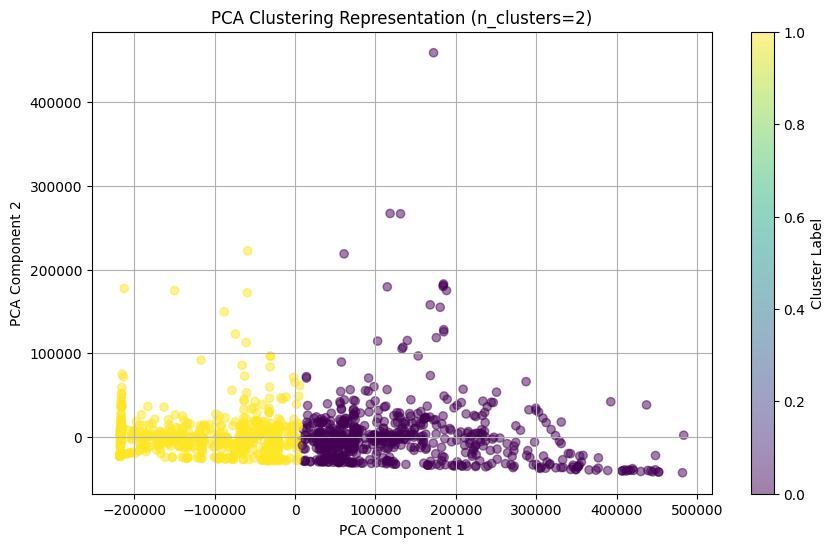

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Assuming resampled_df is already defined and has the features
X = resampled_df.drop('label', axis=1)  # Features

# 1. Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 2. Perform KMeans clustering with n_clusters=2
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# 3. Plot the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('PCA Clustering Representation (n_clusters=2)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid()

# Show the plot
plt.show()
